In [1]:
import yavalath as yav
import mcts
import alphabeta as ab
import numpy as np
import time
import sys
import os
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from functools import partial

0. Setting up the 10 Testboards

In [2]:
def setup_new_board(first_player, second_player):
    board = yav.Board()
    board.setup(first_player, second_player)
    return board

# Board 1 (empty)
board_1 = setup_new_board([],[])
# Board 2
first_player = [(5,3),(5,6)]
second_player = [(4,5),(5,4)]
board_2 = setup_new_board(first_player, second_player)
# Board 3
first_player = [(5,4),(5,6),(8,6)]
second_player = [(4,4),(5,5),(7,6)]
board_3 = setup_new_board(first_player, second_player)
# Board 4
first_player = [(3,2),(3,5),(0,2),(5,2)]
second_player = [(5,4),(3,3),(2,2),(2,4)]
board_4 = setup_new_board(first_player, second_player)
# Board 5
first_player = [(2,2),(2,3),(5,3),(5,6)]
second_player = [(1,1),(3,3),(4,4),(5,4)]
board_5 = setup_new_board(first_player, second_player)
# Board 6
first_player = [(2,2),(3,1),(3,3),(3,4),(4,3),(5,5)]
second_player = [(2,1),(2,4),(3,2),(4,4),(5,1),(5,4)]
board_6 = setup_new_board(first_player, second_player)
# Board 7
first_player = [(1,4),(2,2),(3,4),(4,3),(4,4),(4,6),(4,7)]
second_player = [(2,1),(2,3),(2,4),(3,6),(4,5),(5,3),(5,6)]
board_7 = setup_new_board(first_player, second_player)
# Board 8
first_player = [(1,2),(2,1),(2,3),(2,4),(3,3),(4,2),(4,5),(5,4),(7,5)]
second_player = [(0,2),(1,0),(2,2),(3,2),(3,4),(3,5),(4,3),(5,3),(6,5)]
board_8 = setup_new_board(first_player, second_player)
# Board 9
first_player = [(1,2),(2,4),(3,2),(3,3),(3,6),(4,1),(4,4),(4,5),(4,7),(5,3),(5,4),(5,7),(6,5),(6,6),(7,4)]
second_player = [(0,1),(2,2),(2,3),(2,6),(3,1),(3,4),(4,0),(4,2),(4,3),(4,6),(5,2),(5,5),(5,6),(5,8),(6,4)]
board_9 = setup_new_board(first_player, second_player)
# Board 10
first_player = [(0,0),(0,3),(1,2),(2,4),(3,3),(3,6),(3,7),(4,5),(5,4),(5,5),(5,7),(5,8),(6,3),(6,6),(7,5),(7,6),(8,8)]
second_player = [(0,2),(1,1),(1,4),(2,3),(3,2),(3,5),(4,1),(4,4),(4,7),(5,3),(5,6),(6,5),(6,7),(6,8),(7,4),(7,7),(8,6)]
board_10 = setup_new_board(first_player, second_player)


boards = [board_1, board_2, board_3, board_4, board_5, board_6, board_7, board_8, board_9, board_10]

1. Vergleich von Berechnungszeiten von Alpha-Beta (mit/ohne Transpositiontable und Iterative Deepening)

In [ ]:
# Ergebung der Daten
execute_again = False
if execute_again:
    with open('data/alphabeta_comptime.csv','w', newline='') as csvfile:
        fieldnames = ['board_nr','use_tt','use_iterdeep','depth','time','nodes_visited','move']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for i in range(len(boards)):
            board = boards[i]
            for use_tt in [True]: # TODO after running change back
                for depth in range(4,7):
                    print(f'board_{i+1} use_tt={use_tt} depth={depth}')
                    # No Iterative Deepening
                    ab_object = ab.Alpha_Beta(board,search_depth=depth,use_tt=use_tt)
                    start_time = time.time()
                    move = ab_object.alpha_beta()
                    comp_time = time.time() - start_time 
                    writer.writerow({
                        'board_nr': i+1,
                        'use_tt': use_tt,
                        'use_iterdeep': False,
                        'depth': depth,
                        'time': comp_time,
                        'nodes_visited': ab_object.nodes_visited,
                        'move': move
                        })
                    
                    #Using Iterative Deepening
                    ab_object = ab.Alpha_Beta(board,search_depth=depth,use_tt=use_tt)
                    start_time = time.time()
                    # detect_sudden_end_k=depth sorgt dafür, dass nach Tiefe=depth aufgehört wird
                    move, _ = ab_object.iterative_deepening(max_time=1000,detect_sudden_end_k=depth)
                    comp_time = time.time() - start_time 
                    writer.writerow({
                        'board_nr': i+1,
                        'use_tt': use_tt,
                        'use_iterdeep': True,
                        'depth': depth,
                        'time': comp_time,
                        'nodes_visited': ab_object.nodes_visited,
                        'move': move
                        })


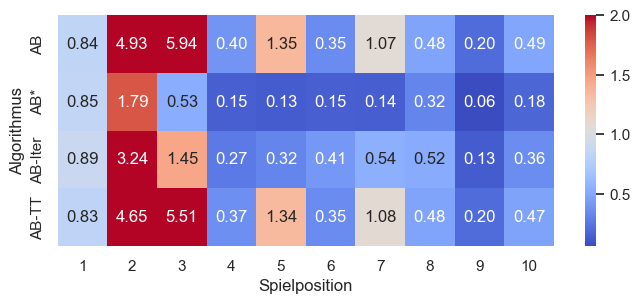

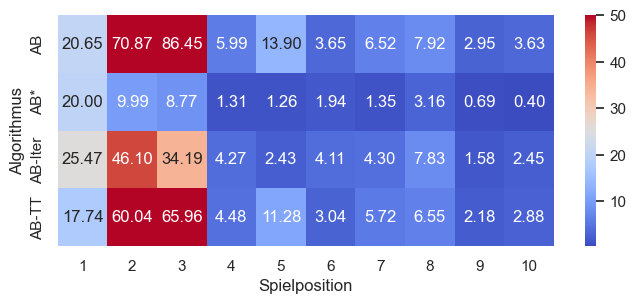

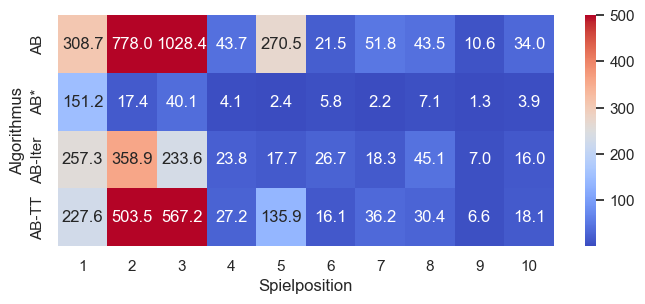

algorithm      AB   AB-TT  AB-Iter    AB*
depth                                    
4            1.61    1.53     0.81   0.43
5           22.25   17.99    13.27   4.89
6          259.08  156.87   100.44  23.54


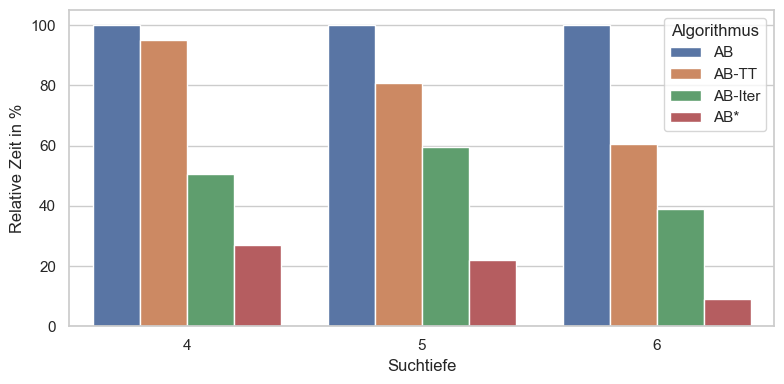

"print(partial_df[partial_df['board_nr']==6].sort_values(by=['depth','expected_rank']))\n\nprint(partial_df[partial_df['algorithm']=='AB*'].sort_values(by=['depth','time'], ascending=[True,False]))"

In [17]:
# Verarbeitung und Plotten der Daten

"""df = pd.read_csv('data/alphabeta_comptime.csv')

filtered_df = df[
    (df['depth'] == 5) &
    (df['use_tt'] == True)
]
print(filtered_df)"""

# AT DEPTH 5;
# when not using tt iterdeep can be worse  (1 and 6)
# when using tt iterdeep only for empty position worse (1)
# when using iter deep using tt aswell always improves
# when not using iter deepo using tt always improves
# -> using tt always improves, iter_can can be worse a few times

df = pd.read_csv('data/alphabeta_comptime.csv')

order = ['AB', 'AB-TT', 'AB-Iter', 'AB*']

def get_algorithm(row):
    if not row['use_tt'] and not row['use_iterdeep']:
        return 'AB'
    elif not row['use_tt'] and row['use_iterdeep']:
        return 'AB-Iter'
    elif row['use_tt'] and not row['use_iterdeep']:
        return 'AB-TT'
    else:
        return 'AB*'
    
def get_algorithm_number(row):
    if row['algorithm'] == 'AB':
        return 0
    elif row['algorithm'] == 'AB-TT':
        return 1
    elif row['algorithm'] == 'AB-Iter':
        return 2
    else:
        return 3
    
df['algorithm'] = df.apply(get_algorithm, axis=1)
df['alg_number'] = df.apply(get_algorithm_number, axis=1)

"""
df_filtered = df[['board_nr','depth','time','algorithm','alg_number']].loc[df['board_nr']==1]
df_filtered = df_filtered.sort_values(by=['board_nr','depth','alg_number'])
print(df_filtered)
"""
sns.set_theme(style="whitegrid")

heatmap_data_4 = df[df['depth'] == 4].pivot(index='algorithm', columns='board_nr', values='time').round(2)
heatmap_data_5 = df[df['depth'] == 5].pivot(index='algorithm', columns='board_nr', values='time').round(2)
heatmap_data_6 = df[df['depth'] == 6].pivot(index='algorithm', columns='board_nr', values='time').round(1)
plt.figure(figsize=(8,3))
sns.heatmap(heatmap_data_4, annot=True, cmap="coolwarm", fmt=".2f",vmax=2)
#plt.title('Rechenzeiten je Spielstellung und Algorithmus (Suchtiefe 4)')
plt.xlabel('Spielposition')
plt.ylabel('Algorithmus')
plt.show()
plt.figure(figsize=(8,3))
sns.heatmap(heatmap_data_5, annot=True, cmap="coolwarm", fmt=".2f",vmax=50)
#plt.title('Rechenzeiten je Spielstellung und Algorithmus (Suchtiefe 5)')
plt.xlabel('Spielposition')
plt.ylabel('Algorithmus')
plt.show()
plt.figure(figsize=(8,3))
sns.heatmap(heatmap_data_6, annot=True, cmap="coolwarm", fmt=".1f",vmax=500)
#plt.title('Rechenzeiten je Spielstellung und Algorithmus (Suchtiefe 6)')
plt.xlabel('Spielposition')
plt.ylabel('Algorithmus')
plt.show()

summary = df.groupby(['algorithm', 'depth'])['time'].agg(['mean','std']).reset_index()

table_mean = summary.pivot(index='depth', columns='algorithm', values='mean').round(2).reindex(columns=order)
print(table_mean)
table_std = summary.pivot(index='depth', columns='algorithm', values='std').round(2).reindex(columns=order)
#print(table_std)

max_time_per_depth = summary.groupby(['depth'])['mean'].max().rename('max_time')
summary_with_max = summary.merge(max_time_per_depth, on='depth', how='left')
summary_with_max['relative_time'] = summary_with_max['mean'] / summary_with_max['max_time'] * 100

sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 4))
sns.barplot(data=summary_with_max, x='depth', y='relative_time', hue='algorithm', hue_order=order)
#plt.title("Relative durchschnittliche Rechenzeit pro Suchtiefe und Algorithmus")
plt.ylabel("Relative Zeit in %")
plt.xlabel("Suchtiefe")
plt.legend(title="Algorithmus")
plt.tight_layout()
plt.show()

"""partial_df = df[['board_nr','algorithm','depth','time']]

order_map = {alg: i for i, alg in enumerate(order)}
partial_df['expected_rank'] = partial_df['algorithm'].map(order_map)

for i in range(1, len(boards)+1):
    board_df = partial_df[partial_df['board_nr']==i]
    for d in range(4,7):
        depth_df = board_df[board_df['depth']==d]
        time_df = depth_df.sort_values('time',ascending=False).reset_index(drop=True)
        wrong_order = time_df[time_df.index < time_df['expected_rank']]
        if not wrong_order.empty:
            print(wrong_order)"""

"""print(partial_df[partial_df['board_nr']==6].sort_values(by=['depth','expected_rank']))

print(partial_df[partial_df['algorithm']=='AB*'].sort_values(by=['depth','time'], ascending=[True,False]))"""

2. Testen der Boards auf Ausgeglichenheit

In [ ]:
execute_again = False
if execute_again:
    with open('data/check_boards_winrate.csv','w', newline='') as csvfile:
        fieldnames = ['board_nr','board_flipped','wins_player1','wins_player2','draws','winrate_p1']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for i in range(1,len(boards)):
            for flipped in [False, True]:
                print(f'now: board_{i+1} flipped={flipped}')
                
                wins = [0,0,0]
                for n in range(10):
                    print(f'game {n}')
                    result = 0
                    board_copy = boards[i].flipped_copy() if flipped else boards[i].copy()
                    while not board_copy.is_over:
                        move = mcts.MCTS_PNS(board_copy,c=np.sqrt(2),use_gdk=True,max_time=3)
                        result = board_copy.do_move(move)
                    player = board_copy.move_count%2
                    winner = player if result==1 else (((player+1) % 2) if result==-1 else 2)
                    wins[winner] += 1
                winrate = wins[0]/30
                writer.writerow({'board_nr': i+1, 'board_flipped': flipped, 'wins_player1': wins[0],'wins_player2': wins[1],'draws': wins[2],'winrate_p1': winrate})



now: board_2 flipped=False
game 0
game 10
game 20
now: board_2 flipped=True
game 0
game 10
game 20
now: board_3 flipped=False
game 0
game 10
game 20
now: board_3 flipped=True
game 0
game 10
game 20
now: board_4 flipped=False
game 0
game 10
game 20
now: board_4 flipped=True
game 0
game 10
game 20
now: board_5 flipped=False
game 0
game 10
game 20
now: board_5 flipped=True
game 0
game 10
game 20
now: board_6 flipped=False
game 0
game 10
game 20
now: board_6 flipped=True
game 0
game 10
game 20
now: board_7 flipped=False
game 0
game 10
game 20
now: board_7 flipped=True
game 0
game 10
game 20
now: board_8 flipped=False
game 0
game 10
game 20
now: board_8 flipped=True
game 0
game 10
game 20
now: board_9 flipped=False
game 0
game 10
game 20
now: board_9 flipped=True
game 0
game 10
game 20
now: board_10 flipped=False
game 0
game 10
game 20
now: board_10 flipped=True
game 0
game 10
game 20


3. Vergleich von c Werten für MCTS (mit/ohne GDK)

In [ ]:
# Definition von Funktionen
def one_game_only_mcts(algorithms, starting, board: yav.Board):
    result = 0
    turn = starting-1
    while result == 0:
        move = algorithms[turn](board)[0]
        result = board.do_move(move)
        turn = (turn+1) % 2
    winner = turn+1 if result==-1 else (((turn+1)%2)+1 if result==1 else 0.5)
    return winner

def round_robin_mcts(algorithms, boards, positions: list, n_repeat_matchups):
    games = []
    game_id = 0
    matchups = list(combinations(algorithms,2))

    for board_nr in positions:
        for alg1, alg2 in matchups:
            print(f'now: board{board_nr}: {alg1.keywords} vs. {alg2.keywords}')
            for repetition in range(n_repeat_matchups):
                print(repetition)
                # alg1 starts
                board = boards[board_nr-1].copy()
                winner = one_game_only_mcts([alg1, alg2],starting=0,board=board)
                games.append({
                    "game_id": game_id,
                    "board_nr": board_nr,
                    "player1_c":alg1.keywords["c"],
                    "player2_c":alg2.keywords["c"],
                    "use_gdk":alg1.keywords["use_gdk"],
                    "starting_player": 1,
                    "winner": winner,
                    "repetition": repetition
                })
                game_id +=1

                # alg2 starts
                board = boards[board_nr-1].copy()
                winner = one_game_only_mcts([alg1, alg2],starting=1,board=board)
                games.append({
                    "game_id": game_id,
                    "board_nr": board_nr,
                    "player1_c":alg1.keywords["c"],
                    "player2_c":alg2.keywords["c"],
                    "use_gdk":alg1.keywords["use_gdk"],
                    "starting_player": 2,
                    "winner": winner,
                    "repetition": repetition
                })
                game_id +=1
    return games
    
    

In [ ]:
# Definition der c Werte und Boards
mcts_func = mcts.MCTS
list_of_c = [0.5,1.0,np.sqrt(2),2.0]
algorithms = []
for i in range(len(list_of_c)):
    algorithms.append(partial(mcts_func,c=list_of_c[i],use_gdk=False,max_time=1))
positions = [1]

In [ ]:
# Round robin MCTS ohne GDK mit verschiedenen c-Werten
execute_again = False
if execute_again:
    edit = os.path.exists('data/compare_c_mcts.csv')
    mode = 'a' if edit else 'w'
    with open('data/compare_c_mcts.csv',mode, newline='') as csvfile:
        fieldnames = ['game_id','board_nr','player1_c','player2_c','use_gdk','starting_player','winner','repetition']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        if not edit:
            writer.writeheader()
        games = round_robin_mcts(algorithms=algorithms,boards=boards,positions=positions,n_repeat_matchups=30)
        writer.writerows(games)

now: board1: {'c': 0.5, 'use_gdk': False, 'max_time': 1} vs. {'c': 1.0, 'use_gdk': False, 'max_time': 1}
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
now: board1: {'c': 0.5, 'use_gdk': False, 'max_time': 1} vs. {'c': np.float64(1.4142135623730951), 'use_gdk': False, 'max_time': 1}
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
now: board1: {'c': 0.5, 'use_gdk': False, 'max_time': 1} vs. {'c': 2.0, 'use_gdk': False, 'max_time': 1}
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
now: board1: {'c': 1.0, 'use_gdk': False, 'max_time': 1} vs. {'c': np.float64(1.4142135623730951), 'use_gdk': False, 'max_time': 1}
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
now: board1: {'c': 1.0, 'use_gdk': False, 'max_time': 1} vs. {'c': 2.0, 'use_gdk': False, 'max_time': 1}
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
now: board1: {'c': np

                      matchup  winner_c  wins  total_games   winrate
0                  0.5 vs 1.0  0.500000    35           60  0.583333
1                  0.5 vs 1.0  1.000000    25           60  0.416667
2   0.5 vs 1.4142135623730951  0.500000    30           60  0.500000
3   0.5 vs 1.4142135623730951  1.414214    30           60  0.500000
4                  0.5 vs 2.0  0.500000    34           60  0.566667
5                  0.5 vs 2.0  2.000000    26           60  0.433333
6   1.0 vs 1.4142135623730951  1.000000    36           60  0.600000
7   1.0 vs 1.4142135623730951  1.414214    24           60  0.400000
8                  1.0 vs 2.0  1.000000    28           60  0.466667
9                  1.0 vs 2.0  2.000000    32           60  0.533333
10  1.4142135623730951 vs 2.0  1.414214    38           60  0.633333
11  1.4142135623730951 vs 2.0  2.000000    22           60  0.366667
          wins  total_games   winrate
0.500000    99          180  0.550000
1.414214    92          180

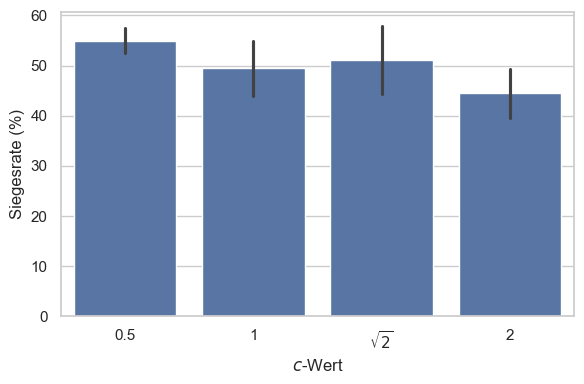

In [46]:
# Verarbeitung und Plotten der Daten

df = pd.read_csv('data/compare_c_mcts.csv')

def get_matchup(row):
    players = sorted([row['player1_c'], row['player2_c']])
    return f"{players[0]} vs {players[1]}"

df['matchup'] = df.apply(get_matchup, axis=1)

df['winner_c'] = df.apply(
    lambda row: row['player1_c'] if row['winner'] == 1 else (row['player2_c'] if row['winner'] == 2 else -1),
    axis=1
)


matchup_wins = df.groupby(['matchup', 'winner_c']).size().reset_index(name='wins')

matchup_games = df.groupby('matchup').size().reset_index(name='total_games')

matchup_stats = pd.merge(matchup_wins, matchup_games, on='matchup')

matchup_stats['winrate'] = matchup_stats['wins'] / matchup_stats['total_games']

print(matchup_stats)

wins = df['winner_c'].value_counts().rename('wins')
#print(wins)
player1_counts = df['player1_c'].value_counts()
player2_counts = df['player2_c'].value_counts()
player1_counts.loc[2.0] = 0
player2_counts.loc[0.5] = 0
total_games = (player1_counts + player2_counts).rename('total_games')

winrate_df = pd.concat([wins, total_games], axis=1).fillna(0)
winrate_df['winrate'] = winrate_df['wins'] / winrate_df['total_games']

print(winrate_df)

stats = matchup_stats.groupby('winner_c')['winrate'].agg(['mean','std'])
print(stats)

matchup_stats['winrate'] = matchup_stats['winrate'] * 100

sns.set_theme(style="whitegrid")
plt.figure(figsize=(6,4))
barplot = sns.barplot(
    data=matchup_stats,
    x='winner_c',
    y='winrate',
    estimator='mean',
    errorbar=('se')
)

barplot.set_xlabel(r"$c$-Wert")
barplot.set_ylabel("Siegesrate (%)")

plt.xticks(ticks=range(4), labels=[0.5,1,r'$\sqrt{2}$',2])
plt.tight_layout()
plt.show()

Wiederholung für c=0.5 und c=$\sqrt2$ mit mehr Zeit

In [ ]:
# Definition der c Werte und Boards
mcts_func = mcts.MCTS
list_of_c = [0.5,np.sqrt(2)]
algorithms = []
for i in range(len(list_of_c)):
    algorithms.append(partial(mcts_func,c=list_of_c[i],use_gdk=False,max_time=10))
positions = [1]

In [ ]:
# Round robin MCTS ohne GDK mit verschiedenen c-Werten
execute_again = False
if execute_again:
    edit = os.path.exists('data/compare_c_mcts_more_time.csv')
    mode = 'a' if edit else 'w'
    with open('data/compare_c_mcts_more_time.csv',mode, newline='') as csvfile:
        fieldnames = ['game_id','board_nr','player1_c','player2_c','use_gdk','starting_player','winner','repetition']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        if not edit:
            writer.writeheader()
        games = round_robin_mcts(algorithms=algorithms,boards=boards,positions=positions,n_repeat_matchups=30)
        writer.writerows(games)

now: board1: {'c': 0.5, 'use_gdk': False, 'max_time': 10} vs. {'c': np.float64(1.4142135623730951), 'use_gdk': False, 'max_time': 10}
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


                     matchup  winner_c  wins  total_games   winrate
0  0.5 vs 1.4142135623730951  0.500000    37           60  0.616667
1  0.5 vs 1.4142135623730951  1.414214    23           60  0.383333
          wins  total_games   winrate
0.500000    37           60  0.616667
1.414214    23           60  0.383333


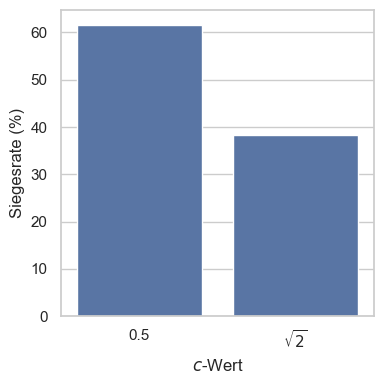

In [53]:
# Verarbeitung und Plotten der Daten

df = pd.read_csv('data/compare_c_mcts_more_time.csv')

def get_matchup(row):
    players = sorted([row['player1_c'], row['player2_c']])
    return f"{players[0]} vs {players[1]}"

df['matchup'] = df.apply(get_matchup, axis=1)

df['winner_c'] = df.apply(
    lambda row: row['player1_c'] if row['winner'] == 1 else row['player2_c'],
    axis=1
)

matchup_wins = df.groupby(['matchup', 'winner_c']).size().reset_index(name='wins')

matchup_games = df.groupby('matchup').size().reset_index(name='total_games')

matchup_stats = pd.merge(matchup_wins, matchup_games, on='matchup')

matchup_stats['winrate'] = matchup_stats['wins'] / matchup_stats['total_games']

print(matchup_stats)

wins = df['winner_c'].value_counts().rename('wins')
#print(wins)
player1_counts = df['player1_c'].value_counts()
player2_counts = df['player2_c'].value_counts()
player1_counts.loc[np.sqrt(2)] = 0
player2_counts.loc[0.5] = 0
total_games = (player1_counts + player2_counts).rename('total_games')

winrate_df = pd.concat([wins, total_games], axis=1).fillna(0)
winrate_df['winrate'] = winrate_df['wins'] / winrate_df['total_games']

print(winrate_df)
winrate_df = winrate_df.reset_index()


winrate_df['winrate'] = winrate_df['winrate'] * 100

sns.set(style="whitegrid")
plt.figure(figsize=(4,4))
barplot = sns.barplot(
    data=winrate_df,
    x='index',
    y='winrate'
)

barplot.set_xlabel(r"$c$-Wert")
barplot.set_ylabel("Siegesrate (%)")

plt.xticks(ticks=range(2), labels=[0.5,r'$\sqrt{2}$'])
plt.tight_layout()
plt.show()

In [110]:
# Neue funktion für das Spielen von nur mcts um zwischen nutzung von gdk unterscheiden zu können
def round_robin_mcts_both_gdk(algorithms, boards, positions: list, n_repeat_matchups):
    games = []
    game_id = 0
    matchups = list(combinations(algorithms,2))

    for board_nr in positions:
        for alg1, alg2 in matchups:
            print(f'now: board{board_nr}: {alg1.keywords} vs. {alg2.keywords}')
            for repetition in range(n_repeat_matchups):
                print(repetition)
                # alg1 starts
                board = boards[board_nr-1].copy()
                winner = one_game_only_mcts([alg1, alg2],starting=0,board=board)
                games.append({
                    "game_id": game_id,
                    "board_nr": board_nr,
                    "player1_c":alg1.keywords["c"],
                    "player2_c":alg2.keywords["c"],
                    "use_gdk_p1":alg1.keywords["use_gdk"],
                    "use_gdk_p2":alg2.keywords["use_gdk"],
                    "starting_player": 1,
                    "winner": winner,
                    "repetition": repetition
                })
                game_id +=1

                # alg2 starts
                board = boards[board_nr-1].copy()
                winner = one_game_only_mcts([alg1, alg2],starting=1,board=board)
                games.append({
                    "game_id": game_id,
                    "board_nr": board_nr,
                    "player1_c":alg1.keywords["c"],
                    "player2_c":alg2.keywords["c"],
                    "use_gdk_p1":alg1.keywords["use_gdk"],
                    "use_gdk_p2":alg2.keywords["use_gdk"],
                    "starting_player": 2,
                    "winner": winner,
                    "repetition": repetition
                })
                game_id +=1
    return games

In [56]:
# Definition der c Werte und Boards

algorithms = []
algorithms.append(partial(mcts.MCTS, c=0.5, use_gdk=False, max_time=10))
algorithms.append(partial(mcts.MCTS, c=0.5, use_gdk=True, max_time=10))
positions = [1]

In [ ]:
# MCTS ohne vs. mit GDK mit c=0.5
execute_again = False
if execute_again:
    edit = os.path.exists('data/compare_mcts_gdk.csv')
    mode = 'a' if edit else 'w'
    with open('data/compare_mcts_gdk.csv',mode, newline='') as csvfile:
        fieldnames = ['game_id','board_nr','player1_c','player2_c','use_gdk_p1','use_gdk_p2','starting_player','winner','repetition']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        if not edit:
            writer.writeheader()
        games = round_robin_mcts_both_gdk(algorithms=algorithms,boards=boards,positions=positions,n_repeat_matchups=30)
        writer.writerows(games)

now: board1: {'c': 0.5, 'use_gdk': False, 'max_time': 10} vs. {'c': 0.5, 'use_gdk': True, 'max_time': 10}
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


         matchup  winner_gdk  wins  total_games   winrate
0  False vs True       False    10           60  0.166667
1  False vs True        True    50           60  0.833333
   use_gdk   winrate
0     True  0.833333
1    False  0.166667


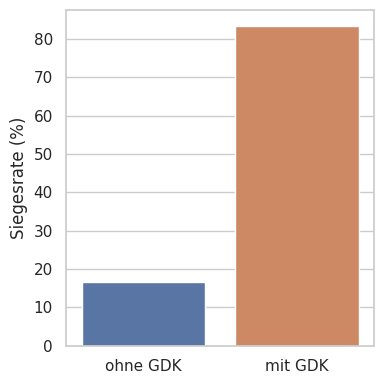

In [90]:
# Verarbeitung und Plotten der Daten

df = pd.read_csv('data/compare_mcts_gdk.csv')

def get_matchup(row):
    players = sorted([row['use_gdk_p1'], row['use_gdk_p2']])
    return f"{players[0]} vs {players[1]}"

df['matchup'] = df.apply(get_matchup, axis=1)

df['winner_gdk'] = df.apply(
    lambda row: row['use_gdk_p1'] if row['winner'] == 1 else row['use_gdk_p2'],
    axis=1
)

matchup_wins = df.groupby(['matchup', 'winner_gdk']).size().reset_index(name='wins')

matchup_games = df.groupby('matchup').size().reset_index(name='total_games')

matchup_stats = pd.merge(matchup_wins, matchup_games, on='matchup')

matchup_stats['winrate'] = matchup_stats['wins'] / matchup_stats['total_games']

print(matchup_stats)

wins = df['winner_gdk'].value_counts().rename('wins')
wins = wins.rename_axis('use_gdk').reset_index(name='wins')
wins['winrate'] = wins['wins'] / 60

print(wins[['use_gdk','winrate']])



wins['winrate'] = wins['winrate'] * 100


sns.set(style="whitegrid")
plt.figure(figsize=(4,4))
barplot = sns.barplot(
    data=wins,
    x='use_gdk',
    y='winrate',
    hue='use_gdk',
    palette='deep'
)

barplot.set_xlabel("")
barplot.set_ylabel("Siegesrate (%)")

plt.xticks(ticks=range(2), labels=["ohne GDK","mit GDK"])
plt.legend().remove()
plt.tight_layout()
plt.show()

Überprüfen der c-Werte für MCTS mit GDK ($0.3,0.5,0.7, \sqrt(2)$)

In [ ]:
# Neue funktionen für das Spielen von nur mcts um die länge der Spiele(Anzahl der Züge) zu dokumentieren

def one_game_only_mcts_n_turns(algorithms, starting, board: yav.Board):
    result = 0
    turn = starting-1
    while result == 0:
        move = algorithms[turn](board)[0]
        result = board.do_move(move)
        turn = (turn+1) % 2
    winner = turn+1 if result==-1 else (((turn+1)%2)+1 if result==1 else 0.5)
    return winner, board.move_count

def round_robin_mcts_n_turns(algorithms, boards, positions: list, n_repeat_matchups):
    games = []
    game_id = 0
    matchups = list(combinations(algorithms,2))

    for board_nr in positions:
        for alg1, alg2 in matchups:
            print(f'now: board{board_nr}: {alg1.keywords} vs. {alg2.keywords}')
            for repetition in range(n_repeat_matchups):
                print(repetition)
                # alg1 starts
                board = boards[board_nr-1].copy()
                winner, n_moves = one_game_only_mcts([alg1, alg2],starting=0,board=board)
                games.append({
                    "game_id": game_id,
                    "board_nr": board_nr,
                    "player1_c":alg1.keywords["c"],
                    "player2_c":alg2.keywords["c"],
                    "use_gdk_p1":alg1.keywords["use_gdk"],
                    "use_gdk_p2":alg2.keywords["use_gdk"],
                    "starting_player": 1,
                    "winner": winner,
                    "repetition": repetition,
                    "n_moves": n_moves
                })
                game_id +=1

                # alg2 starts
                board = boards[board_nr-1].copy()
                winner, n_moves = one_game_only_mcts([alg1, alg2],starting=1,board=board)
                games.append({
                    "game_id": game_id,
                    "board_nr": board_nr,
                    "player1_c":alg1.keywords["c"],
                    "player2_c":alg2.keywords["c"],
                    "use_gdk_p1":alg1.keywords["use_gdk"],
                    "use_gdk_p2":alg2.keywords["use_gdk"],
                    "starting_player": 2,
                    "winner": winner,
                    "repetition": repetition,
                    "n_moves": n_moves
                })
                game_id +=1
    return games

In [137]:
# Definition der c Werte und Boards

"""algorithms = []
algorithms.append(partial(mcts.MCTS, c=0.3, use_gdk=True, max_time=1))
algorithms.append(partial(mcts.MCTS, c=0.5, use_gdk=True, max_time=1))
algorithms.append(partial(mcts.MCTS, c=0.7, use_gdk=True, max_time=1))
algorithms.append(partial(mcts.MCTS, c=np.sqrt(2), use_gdk=True, max_time=1))
positions = [1]"""
algorithms = []
algorithms.append(partial(mcts.MCTS, c=0.3, use_gdk=True, max_time=5))
algorithms.append(partial(mcts.MCTS, c=0.7, use_gdk=True, max_time=5))
algorithms.append(partial(mcts.MCTS, c=np.sqrt(2), use_gdk=True, max_time=5))
positions = [1]

In [ ]:
# MCTS mit GDK und verschiednen c-werten
execute_again = False
if execute_again:
    edit = os.path.exists('data/mcts_gdk_c_values_5_seconds.csv')
    mode = 'a' if edit else 'w'
    with open('data/mcts_gdk_c_values_5_seconds.csv',mode, newline='') as csvfile:
        fieldnames = ['game_id','board_nr','player1_c','player2_c','use_gdk_p1','use_gdk_p2','starting_player','winner','repetition','n_moves']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        if not edit:
            writer.writeheader()
        games = round_robin_mcts_n_turns(algorithms=algorithms,boards=boards,positions=positions,n_repeat_matchups=30)
        writer.writerows(games)

now: board1: {'c': 0.3, 'use_gdk': True, 'max_time': 5} vs. {'c': 0.7, 'use_gdk': True, 'max_time': 5}
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
now: board1: {'c': 0.3, 'use_gdk': True, 'max_time': 5} vs. {'c': np.float64(1.4142135623730951), 'use_gdk': True, 'max_time': 5}
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
now: board1: {'c': 0.7, 'use_gdk': True, 'max_time': 5} vs. {'c': np.float64(1.4142135623730951), 'use_gdk': True, 'max_time': 5}
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


                      matchup  winner_c  wins  total_games   winrate
0                  0.3 vs 0.5  0.300000    37           60  0.616667
1                  0.3 vs 0.5  0.500000    23           60  0.383333
2                  0.3 vs 0.7  0.300000    32           60  0.533333
3                  0.3 vs 0.7  0.700000    28           60  0.466667
4   0.3 vs 1.4142135623730951  0.300000    33           60  0.550000
5   0.3 vs 1.4142135623730951  1.414214    27           60  0.450000
6                  0.5 vs 0.7  0.500000    30           60  0.500000
7                  0.5 vs 0.7  0.700000    30           60  0.500000
8   0.5 vs 1.4142135623730951  0.500000    30           60  0.500000
9   0.5 vs 1.4142135623730951  1.414214    30           60  0.500000
10  0.7 vs 1.4142135623730951  0.700000    33           60  0.550000
11  0.7 vs 1.4142135623730951  1.414214    27           60  0.450000
          wins  total_games   winrate
0.300000   102          180  0.566667
0.700000    91          180

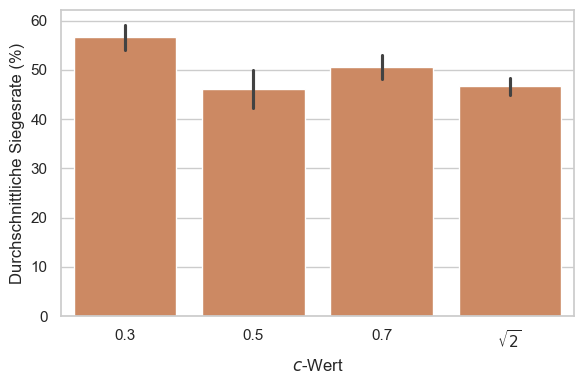

In [54]:
# Verarbeitung und Plotten der Daten 1 sekunde Zugzeit

df = pd.read_csv('data/mcts_gdk_c_values.csv')

def get_matchup(row):
    players = sorted([row['player1_c'], row['player2_c']])
    return f"{players[0]} vs {players[1]}"

df['matchup'] = df.apply(get_matchup, axis=1)

df['winner_c'] = df.apply(
    lambda row: row['player1_c'] if row['winner'] == 1 else row['player2_c'],
    axis=1
)

matchup_wins = df.groupby(['matchup', 'winner_c']).size().reset_index(name='wins')

matchup_games = df.groupby('matchup').size().reset_index(name='total_games')

matchup_stats = pd.merge(matchup_wins, matchup_games, on='matchup')

matchup_stats['winrate'] = matchup_stats['wins'] / matchup_stats['total_games']

print(matchup_stats)

wins = df['winner_c'].value_counts().rename('wins')
#print(wins)
player1_counts = df['player1_c'].value_counts()
player2_counts = df['player2_c'].value_counts()
player1_counts.loc[np.sqrt(2)] = 0
player2_counts.loc[0.3] = 0
total_games = (player1_counts + player2_counts).rename('total_games')

winrate_df = pd.concat([wins, total_games], axis=1).fillna(0)
winrate_df['winrate'] = winrate_df['wins'] / winrate_df['total_games']

print(winrate_df) # winrate overall

stats = matchup_stats.groupby('winner_c')['winrate'].agg(['mean','std'])
print(stats)

matchup_stats['winrate'] = matchup_stats['winrate'] * 100

sns.set(style="whitegrid")
plt.figure(figsize=(6,4))
barplot = sns.barplot(
    data=matchup_stats,
    x='winner_c',
    y='winrate',
    estimator='mean',
    errorbar=('se'),
    color=sns.color_palette("deep")[1]
)

barplot.set_xlabel(r"$c$-Wert")
barplot.set_ylabel("Durchschnittliche Siegesrate (%)")

plt.xticks(ticks=range(4), labels=[0.3,0.5,0.7,r'$\sqrt{2}$'])
plt.tight_layout()
plt.show()

                     matchup  winner_c  wins  total_games   winrate
0                 0.3 vs 0.7  0.300000    32           60  0.533333
1                 0.3 vs 0.7  0.700000    28           60  0.466667
2  0.3 vs 1.4142135623730951  0.300000    29           60  0.483333
3  0.3 vs 1.4142135623730951  1.414214    31           60  0.516667
4  0.7 vs 1.4142135623730951  0.700000    35           60  0.583333
5  0.7 vs 1.4142135623730951  1.414214    25           60  0.416667
          wins  total_games   winrate
0.700000    63          120  0.525000
0.300000    61          120  0.508333
1.414214    56          120  0.466667
              mean       std
winner_c                    
0.300000  0.508333  0.035355
0.700000  0.525000  0.082496
1.414214  0.466667  0.070711


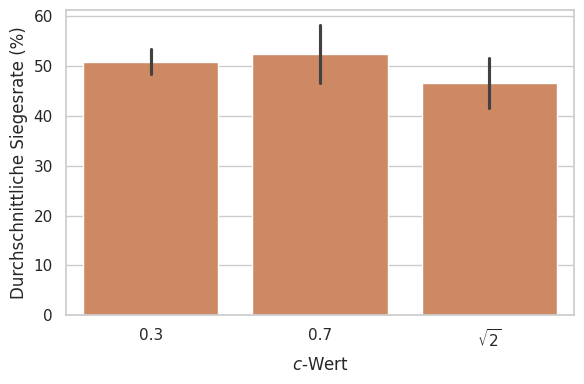

In [95]:
# Verarbeitung und Plotten der Daten 5 sekunde Zugzeit

df = pd.read_csv('data/mcts_gdk_c_values_5_seconds.csv')

def get_matchup(row):
    players = sorted([row['player1_c'], row['player2_c']])
    return f"{players[0]} vs {players[1]}"

df['matchup'] = df.apply(get_matchup, axis=1)

df['winner_c'] = df.apply(
    lambda row: row['player1_c'] if row['winner'] == 1 else row['player2_c'],
    axis=1
)

matchup_wins = df.groupby(['matchup', 'winner_c']).size().reset_index(name='wins')

matchup_games = df.groupby('matchup').size().reset_index(name='total_games')

matchup_stats = pd.merge(matchup_wins, matchup_games, on='matchup')

matchup_stats['winrate'] = matchup_stats['wins'] / matchup_stats['total_games']

print(matchup_stats)

wins = df['winner_c'].value_counts().rename('wins')
#print(wins)
player1_counts = df['player1_c'].value_counts()
player2_counts = df['player2_c'].value_counts()
player1_counts.loc[np.sqrt(2)] = 0
player2_counts.loc[0.3] = 0
total_games = (player1_counts + player2_counts).rename('total_games')

winrate_df = pd.concat([wins, total_games], axis=1).fillna(0)
winrate_df['winrate'] = winrate_df['wins'] / winrate_df['total_games']

print(winrate_df) # winrate overall

stats = matchup_stats.groupby('winner_c')['winrate'].agg(['mean','std'])
print(stats)

matchup_stats['winrate'] = matchup_stats['winrate'] * 100

sns.set(style="whitegrid")
plt.figure(figsize=(6,4))
barplot = sns.barplot(
    data=matchup_stats,
    x='winner_c',
    y='winrate',
    estimator='mean',
    errorbar=('se'),
    color=sns.color_palette("deep")[1]
)

barplot.set_xlabel(r"$c$-Wert")
barplot.set_ylabel("Durchschnittliche Siegesrate (%)")

plt.xticks(ticks=range(3), labels=[0.3,0.7,r'$\sqrt{2}$'])
plt.tight_layout()
plt.show()

Number of iterations: 15384


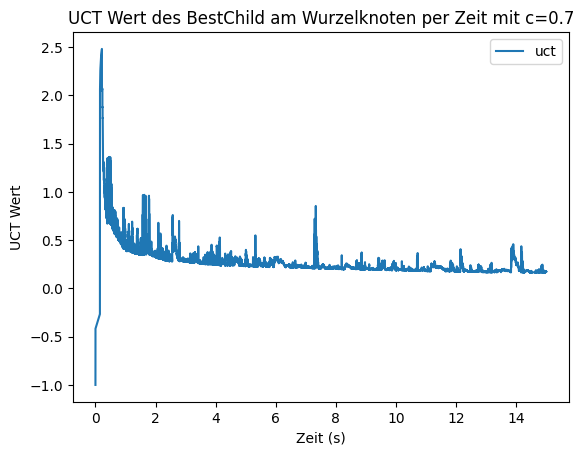

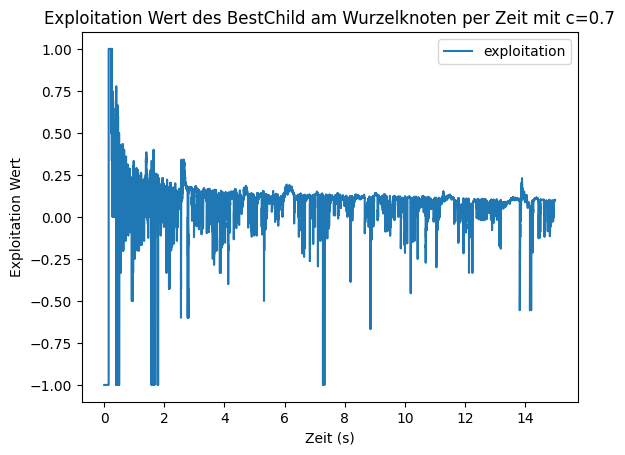

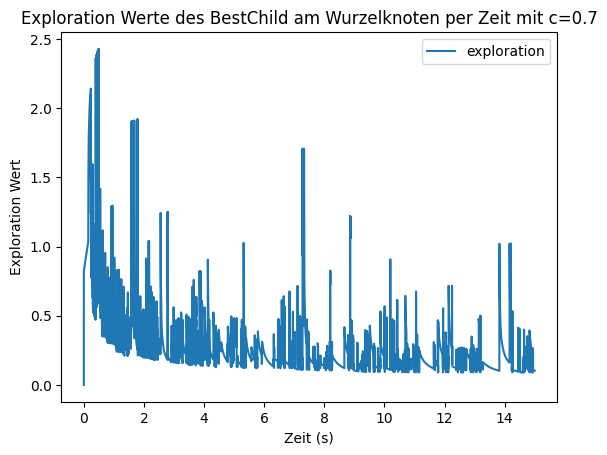

In [8]:
test_board = yav.Board()
m03 = partial(mcts.MCTS,c=0.3,use_gdk=True,max_time=10,plot=True)
m07 = partial(mcts.MCTS,c=0.7,use_gdk=True,max_time=15,plot=True)
"""
move, values = m03(test_board)

df = pd.DataFrame(values)
df.plot(x='time',y='uct',kind='line')
plt.xlabel('Zeit (s)')
plt.ylabel('UCT Wert')
plt.title('UCT Wert des BestChild am Wurzelknoten per Zeit mit c=0.3')
plt.show()

df.plot(x='time',y='exploitation',kind='line')
plt.xlabel('Zeit (s)')
plt.ylabel('Exploitation Wert')
plt.title('Exploitation Wert des BestChild am Wurzelknoten per Zeit mit c=0.3')
plt.show()

df.plot(x='time',y='exploration',kind='line')
plt.xlabel('Zeit (s)')
plt.ylabel('Exploration Wert')
plt.title('Exploration Werte des BestChild am Wurzelknoten per Zeit mit c=0.3')
plt.show()
"""

move, values = m07(test_board)

df = pd.DataFrame(values)
df.plot(x='time',y='uct',kind='line')
plt.xlabel('Zeit (s)')
plt.ylabel('UCT Wert')
plt.title('UCT Wert des BestChild am Wurzelknoten per Zeit mit c=0.7')
plt.show()

df.plot(x='time',y='exploitation',kind='line')
plt.xlabel('Zeit (s)')
plt.ylabel('Exploitation Wert')
plt.title('Exploitation Wert des BestChild am Wurzelknoten per Zeit mit c=0.7')
plt.show()

df.plot(x='time',y='exploration',kind='line')
plt.xlabel('Zeit (s)')
plt.ylabel('Exploration Wert')
plt.title('Exploration Werte des BestChild am Wurzelknoten per Zeit mit c=0.7')
plt.show()

4. Vergleich der ausgewählten Alpha-Beta und MCTS Varianten

In [ ]:
# Neue funktionen für das Spielen von nur mcts um die länge der Spiele(Anzahl der Züge) zu dokumentieren
def one_move(algorithm, board: yav.Board, follow_sudden_win, max_time):
    sudden_win_found = False
    if algorithm == "MCTS":
        move, n_iter, nodes_expanded = mcts.MCTS(board, c=0.7, use_gdk=True, max_time=max_time)
    elif algorithm == "MCTS-PNS":
        move, n_iter, nodes_expanded = mcts.MCTS_PNS(board, c=0.7,C_pn=1, use_gdk=True, max_time=max_time)
    elif algorithm == "MCTS-AB":
        if follow_sudden_win:
            ab_object = ab.Alpha_Beta(board, use_tt=True)
            move, _ = ab_object.iterative_deepening(max_time=max_time)
            return move,-1,-1,False,-1,-1
        move, n_iter, nodes_expanded, sudden_win_found = mcts.MCTS_alphabeta(board, c=0.7,k=4, use_gdk=True, max_time=max_time)
    else:
        ab_object = ab.Alpha_Beta(board, use_tt=True)
        move, _ = ab_object.iterative_deepening(max_time=max_time)
        nodes_expanded = ab_object.nodes_visited
        depth = ab_object.finished_depth
        n_entries_tptable = len(ab_object.tp_table) # Die ungefähre Größer eines Entries wird später berechnet
        n_iter = 0 # nur für mcts
    
    if algorithm != "AB":
        depth = 0
        n_entries_tptable = 0

    return move, nodes_expanded, n_iter, sudden_win_found, depth, n_entries_tptable


def one_game(algorithms, starting, board: yav.Board, max_time):
    result = 0
    turn = starting-1
    all_n_nodes_p1 = []
    all_n_iter_p1 = []
    all_n_nodes_p2 = []
    all_n_iter_p2 = []

    all_depths = []
    all_n_entries_tptable = []
    
    follow_sudden_win = False

    while result == 0:
        current_alg = algorithms[turn]
        move, nodes_expanded, n_iter, sudden_win_found, depth, n_entries_tptable = one_move(current_alg, board, follow_sudden_win, max_time)
        if (not follow_sudden_win or (follow_sudden_win and algorithms[turn] != "MCTS-AB")) and not (sudden_win_found and algorithms[turn] == "MCTS-AB"):
            if turn == 0:
                all_n_nodes_p1.append(nodes_expanded)
                all_n_iter_p1.append(n_iter)
            else:
                all_n_nodes_p2.append(nodes_expanded)
                all_n_iter_p2.append(n_iter)

            if depth != 0:
                all_depths.append(depth)
                all_n_entries_tptable.append(n_entries_tptable)
        if not follow_sudden_win:
            follow_sudden_win = sudden_win_found
        
        result = board.do_move(move)
        turn = (turn+1) % 2
    winner = turn+1 if result==-1 else (((turn+1)%2)+1 if result==1 else 0.5)
    n_moves = board.move_count
    avg_n_nodes = [avg(all_n_nodes_p1), avg(all_n_nodes_p2)]
    avg_n_iter = [avg(all_n_iter_p1), avg(all_n_iter_p2)]

    if all_depths:
        avg_depth = avg(all_depths)
        max_depth = max(all_depths)
        min_depth = min(all_depths)
    else:
        avg_depth = 0
        max_depth = 0
        min_depth = 0
    avg_n_entries_tptable = avg(all_n_entries_tptable)
    return winner, n_moves, avg_n_nodes, avg_n_iter, follow_sudden_win, avg_depth, max_depth, min_depth, avg_n_entries_tptable

def avg(some_list):
    if some_list:
        return sum(some_list)/len(some_list)
    else:
        0

def general_round_robin(algorithms: list[str], max_time, boards, positions: list, n_repeat_matchups, start_id,skip_matchups_without):
    games = []
    game_id = start_id
    matchups = list(combinations(algorithms,2))

    for board_nr in positions:
        for alg1, alg2 in matchups:
            if not alg1 in skip_matchups_without and not alg2 in skip_matchups_without:
                continue
            print(f'now: board{board_nr}: {alg1} vs. {alg2}')
            for repetition in range(n_repeat_matchups):
                print(game_id)
                # alg1 starts
                board = boards[board_nr-1].copy()
                winner, n_moves, avg_n_nodes, avg_n_iter, sudden_win_found, avg_depth, max_depth, min_depth, avg_n_entries_tptable = one_game([alg1, alg2],starting=0,board=board, max_time=max_time)
                games.append({
                    "game_id": game_id,
                    "board_nr": board_nr,
                    "player1":alg1,
                    "player2":alg2,
                    "starting_player": 1,
                    "winner": winner,
                    "repetition": repetition,
                    "n_moves": n_moves,
                    "player1_avg_n_nodes": avg_n_nodes[0],
                    "player2_avg_n_nodes": avg_n_nodes[1],
                    "player1_avg_n_iter": avg_n_iter[0],
                    "player2_avg_n_iter": avg_n_iter[1],
                    "sudden_win_found": sudden_win_found,
                    "avg_depth": avg_depth,
                    "max_depth": max_depth,
                    "min_depth": min_depth,
                    "avg_n_entries_tptable": avg_n_entries_tptable
                })
                game_id +=1
                print(game_id)
                # alg2 starts
                board = boards[board_nr-1].copy()
                winner, n_moves, avg_n_nodes, avg_n_iter, sudden_win_found, avg_depth, max_depth, min_depth, avg_n_entries_tptable = one_game([alg1, alg2],starting=1,board=board, max_time=max_time)
                games.append({
                    "game_id": game_id,
                    "board_nr": board_nr,
                    "player1":alg1,
                    "player2":alg2,
                    "starting_player": 2,
                    "winner": winner,
                    "repetition": repetition,
                    "n_moves": n_moves,
                    "player1_avg_n_nodes": avg_n_nodes[0],
                    "player2_avg_n_nodes": avg_n_nodes[1],
                    "player1_avg_n_iter": avg_n_iter[0],
                    "player2_avg_n_iter": avg_n_iter[1],
                    "sudden_win_found": sudden_win_found,
                    "avg_depth": avg_depth,
                    "max_depth": max_depth,
                    "min_depth": min_depth,
                    "avg_n_entries_tptable": avg_n_entries_tptable
                })
                game_id +=1
    return games

In [ ]:
algorithms = ["AB","MCTS","MCTS-AB","MCTS-PNS"]
skip_matchups_without = algorithms
positions = [4]
max_time = 5
n_repeat_matchups = 25

start_match_id = 0

# MCTS mit GDK und verschiednen c-werten
execute_again = True
if execute_again:
    edit = os.path.exists('data/round_robin_position_4.csv')
    mode = 'a' if edit else 'w'
    with open('data/round_robin_position_4.csv',mode, newline='') as csvfile:
        fieldnames = ["game_id",
                      "board_nr",
                      "player1",
                      "player2",
                      "starting_player",
                      "winner",
                      "repetition",
                      "n_moves",
                      "player1_avg_n_nodes",
                      "player2_avg_n_nodes",
                      "player1_avg_n_iter",
                      "player2_avg_n_iter",
                      "sudden_win_found",
                      "avg_depth",
                      "max_depth",
                      "min_depth",
                      "avg_n_entries_tptable"]
        
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        if not edit:
            writer.writeheader()
        games = general_round_robin(algorithms,max_time,boards,positions,n_repeat_matchups=n_repeat_matchups, start_id=start_match_id,skip_matchups_without=skip_matchups_without)
        writer.writerows(games)

In [62]:
# Results auswerten und plotten der Siegesraten
df_1 = pd.read_csv('data/round_robin_position_1.csv')
df_2 = pd.read_csv('data/round_robin_position_1_MCTS-AB.csv')

df = pd.concat([df_1,df_2]).reset_index(drop=True)

def get_matchup(row):
    players = sorted([row['player1'], row['player2']])
    return f"{players[0]} vs {players[1]}"

df['matchup'] = df.apply(get_matchup, axis=1)

df['winner_name'] = df.apply(
    lambda row: row['player1'] if row['winner'] == 1 else row['player2'] if row['winner'] == 2 else 'draw', 
    axis=1
)
df_with_draws = df.copy()
#df = df[df['winner_name']!='draw']

matchup_wins = df.groupby(['matchup', 'winner_name']).size().reset_index(name='wins')

matchup_games = df.groupby('matchup').size().reset_index(name='total_games')

matchup_stats = pd.merge(matchup_wins, matchup_games, on='matchup')
matchup_stats['winrate'] = matchup_stats['wins'] / matchup_stats['total_games']


#matchup_stats = matchup_stats[matchup_stats['winner_name'] != 'draw']
print(matchup_stats)

stats = matchup_stats.groupby('winner_name')['winrate'].agg(['mean','std'])
#print(stats)

num_games = 300
algorithms = ['AB', 'MCTS', 'MCTS-AB', 'MCTS-PNS']
for alg in algorithms:
    draws = df_with_draws[((df_with_draws['player1']==alg) | (df_with_draws['player2'] == alg)) & (df_with_draws['winner'] == 0.5)]
    n_draws = len(draws.index)
    print(f'{alg} drew {n_draws} times, that is a drawrate of {n_draws/num_games}')

"""
df_no_ab = df[df['player1']!= 'AB']

matchup_wins = df_no_ab.groupby(['matchup', 'winner_name']).size().reset_index(name='wins')
matchup_games = df_no_ab.groupby('matchup').size().reset_index(name='total_games')
matchup_stats = pd.merge(matchup_wins, matchup_games, on='matchup')
matchup_stats['winrate'] = matchup_stats['wins'] / matchup_stats['total_games']


matchup_stats = matchup_stats[matchup_stats['winner_name'] != 'draw']

stats = matchup_stats.groupby('winner_name')['winrate'].agg(['mean','std'])
print(stats)
"""
print('-')

                matchup winner_name  wins  total_games  winrate
0            AB vs MCTS          AB    38           50     0.76
1            AB vs MCTS        MCTS    12           50     0.24
2         AB vs MCTS-AB          AB    41           50     0.82
3         AB vs MCTS-AB     MCTS-AB     8           50     0.16
4         AB vs MCTS-AB        draw     1           50     0.02
5        AB vs MCTS-PNS          AB    41           50     0.82
6        AB vs MCTS-PNS    MCTS-PNS     9           50     0.18
7       MCTS vs MCTS-AB        MCTS    23           50     0.46
8       MCTS vs MCTS-AB     MCTS-AB    23           50     0.46
9       MCTS vs MCTS-AB        draw     4           50     0.08
10     MCTS vs MCTS-PNS        MCTS    19           50     0.38
11     MCTS vs MCTS-PNS    MCTS-PNS    27           50     0.54
12     MCTS vs MCTS-PNS        draw     4           50     0.08
13  MCTS-AB vs MCTS-PNS     MCTS-AB    22           50     0.44
14  MCTS-AB vs MCTS-PNS    MCTS-PNS    2

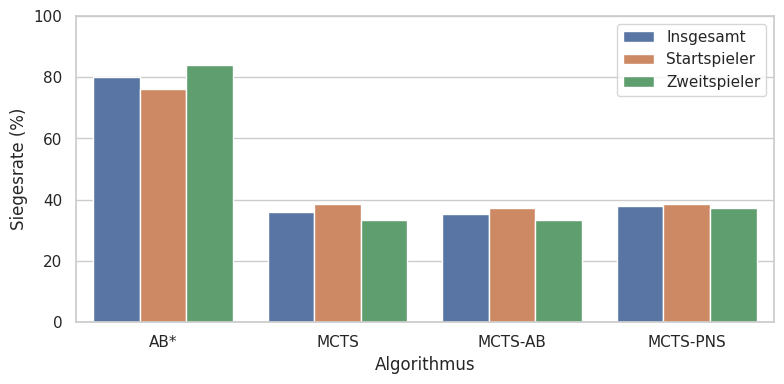

In [59]:
# Winrates when going first

# Results auswerten und plotten der Siegesraten
df_1 = pd.read_csv('data/round_robin_position_1.csv')
df_2 = pd.read_csv('data/round_robin_position_1_MCTS-AB.csv')

df = pd.concat([df_1,df_2],ignore_index=True)

def get_starting_name(row):
    starting = row['starting_player']
    return row[f'player{starting}']

df['starting_name'] = df.apply(get_starting_name, axis=1)
df['winner_name'] = df.apply(
    lambda row: row['player1'] if row['winner'] == 1 else row['player2'] if row['winner'] == 2 else 'draw', 
    axis=1
)

def slice_alg_played(df, alg):
    return df[(df['player1']==alg) | (df['player2'==alg])]

def slice_alg_starts(df, alg):
    return df[df['starting_name']==alg]

def slice_alg_second(df, alg):
    return df[(df['starting_name']!=alg) & ((df['player1'] == alg) |(df['player2']==alg))]

def winrate_overall(df,alg):
    all_games = df[(df['player1']==alg) | (df['player2']==alg)]
    wins = (all_games['winner_name'] == alg).sum()
    #total = (all_games['winner_name']!='draw').sum()
    total = len(all_games)
    winrate = round(wins / total,4)
    return winrate


def winrate_when_first(df, alg):
    starts = df[df['starting_name']==alg]
    wins = (starts['winner_name'] == alg).sum()
    #total = (starts['winner_name']!='draw').sum()
    total = len(starts)
    winrate = round(wins / total,4)
    return winrate

def winrate_when_second(df, alg):
    second = df[(df['starting_name']!=alg) & ((df['player1'] == alg) |(df['player2']==alg))]
    wins = (second['winner_name'] == alg).sum()
    #total = (second['winner_name']!='draw').sum()
    total = len(second)
    winrate = round(wins / total,4)
    return winrate

algorithms = ['AB','MCTS','MCTS-AB','MCTS-PNS']

winrates_overall = []
winrates_first = []
winrates_second = [] 
for alg in algorithms:
    winrates_overall.append(winrate_overall(df,alg))
    winrates_first.append(winrate_when_first(df,alg))
    winrates_second.append(winrate_when_second(df,alg))


df_winrates = pd.DataFrame()

algorithms[0] = 'AB*'
df_winrates['algorithm'] = algorithms + algorithms + algorithms
df_winrates['winrate'] =  [100*i for i in (winrates_overall + winrates_first + winrates_second)]
df_winrates['first_or_second'] = ['Insgesamt','Insgesamt','Insgesamt','Insgesamt','Startspieler','Startspieler','Startspieler','Startspieler','Zweitspieler','Zweitspieler','Zweitspieler','Zweitspieler']

sns.set_theme(style='whitegrid')
plt.figure(figsize=(8, 4))
sns.barplot(data=df_winrates, x="algorithm", y="winrate", hue="first_or_second")
plt.xlabel("Algorithmus")
plt.ylabel("Siegesrate (%)")
plt.ylim(0, 100)
plt.legend(title="")
plt.tight_layout()
plt.show()



algorithm
AB    920485.98733
Name: nodes, dtype: float64


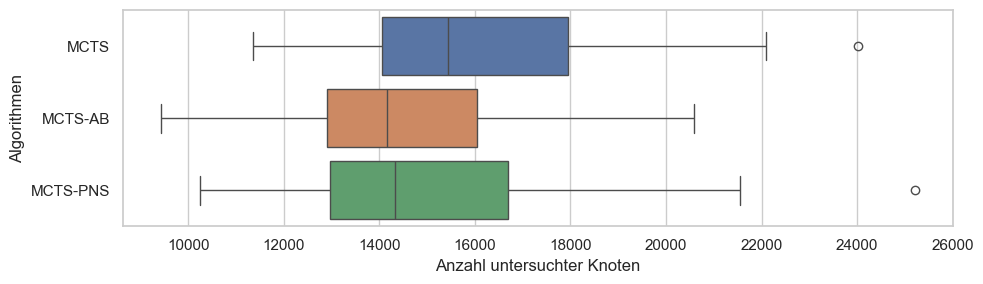

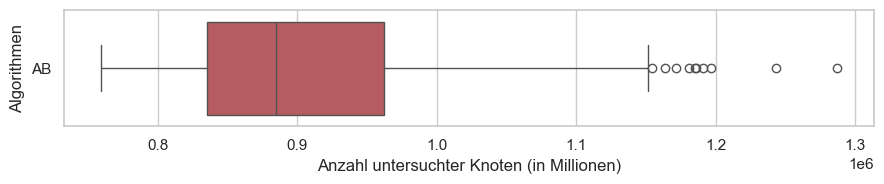

In [5]:
# Results auswerten und plotten der untersuchten Knoten

df_1 = pd.read_csv('data/round_robin_position_1.csv')
df_2 = pd.read_csv('data/round_robin_position_1_MCTS-AB.csv')

df = pd.concat([df_1,df_2]).copy()

nodes_combined = pd.concat([
    df[['player1', 'player1_avg_n_nodes']].rename(columns={'player1': 'algorithm', 'player1_avg_n_nodes': 'nodes'}),
    df[['player2', 'player2_avg_n_nodes']].rename(columns={'player2': 'algorithm', 'player2_avg_n_nodes': 'nodes'})
])

nodes_ab_only = nodes_combined[nodes_combined['algorithm'] == 'AB']
avg_nodes = nodes_ab_only.groupby('algorithm')['nodes'].mean()
print(avg_nodes)


nodes_combined = nodes_combined[nodes_combined['algorithm'] != 'AB']

# Verteilung vorbereiten

sns.set_theme(style="whitegrid")
plt.figure(figsize=(10,3))
sns.boxplot(data=nodes_combined, x='nodes', y='algorithm', orient='h', hue='algorithm')
plt.xlabel('Anzahl untersuchter Knoten')
plt.ylabel('Algorithmen')
plt.tight_layout()
plt.show()

# Verteilung vorbereiten

plt.figure(figsize=(9,2))
ax = sns.boxplot(data=nodes_ab_only, x='nodes', y='algorithm', orient='h',color=sns.color_palette("deep")[3])
ax.ticklabel_format(style='sci', axis='x', scilimits=(0, 2))
plt.xlabel('Anzahl untersuchter Knoten (in Millionen)')
plt.ylabel('Algorithmen')
plt.tight_layout()
plt.show()

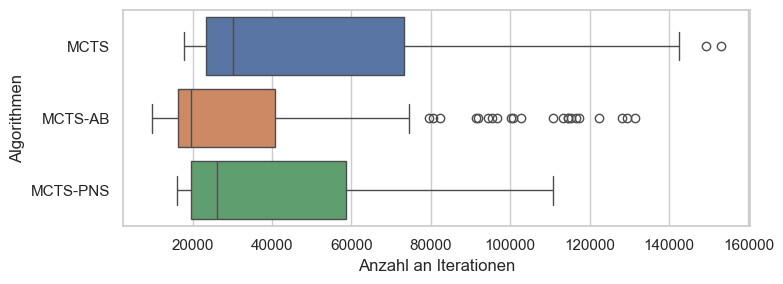

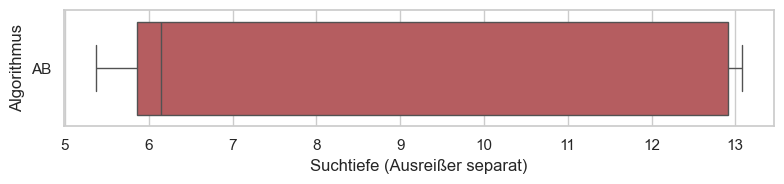

C:\Users\Jan\AppData\Local\Temp\ipykernel_127296\3846842371.py:47: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  outliers = df_depth.groupby('algorithm').apply(get_outliers)


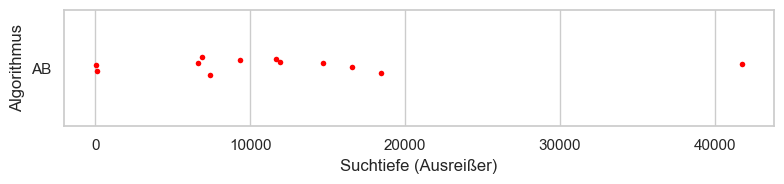

In [6]:
# Results auswerten und plotten der Iterationen von MCTS

df_1 = pd.read_csv('data/round_robin_position_1.csv')
df_2 = pd.read_csv('data/round_robin_position_1_MCTS-AB.csv')

df = pd.concat([df_1,df_2])

iterations_combined = pd.concat([
    df[['player1', 'player1_avg_n_iter']].rename(columns={'player1': 'algorithm', 'player1_avg_n_iter': 'iterations'}),
    df[['player2', 'player2_avg_n_iter']].rename(columns={'player2': 'algorithm', 'player2_avg_n_iter': 'iterations'})
])

#nodes_ab_only = nodes_combined[nodes_combined['algorithm'] == 'AB']

iterations_combined = iterations_combined[iterations_combined['algorithm'] != 'AB']

df_recorded_depth = df[(df['avg_depth'] > 0)]

df_depth = df_recorded_depth[['player1', 'avg_depth']].rename(columns={'player1': 'algorithm', 'avg_depth': 'iterations'})
#nodes_combined = pd.concat([nodes_combined, df_depth])


# Verteilung vorbereiten

sns.set_theme(style="whitegrid")
plt.figure(figsize=(8,3))
sns.boxplot(data=iterations_combined, x='iterations', y='algorithm', orient='h', hue='algorithm')
plt.xlabel('Anzahl an Iterationen')
plt.ylabel('Algorithmen')
plt.tight_layout()
plt.show()

def get_outliers(subdf):
    Q1 = subdf['iterations'].quantile(0.25)
    Q3 = subdf['iterations'].quantile(0.75)
    IQR = Q3 - Q1
    return subdf[(subdf['iterations'] < Q1 - 1.5 * IQR) | (subdf['iterations'] > Q3 + 1.5 * IQR)]

plt.figure(figsize=(8,2))
sns.boxplot(data=df_depth, x='iterations', y='algorithm', orient='h', showfliers=False, color=sns.color_palette("deep")[3])
plt.xlabel('Suchtiefe (Ausreißer separat)')
plt.ylabel('Algorithmus')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,2))
outliers = df_depth.groupby('algorithm').apply(get_outliers)
sns.stripplot(data=outliers, x='iterations', y='algorithm', color='red', jitter=True, size=4)
plt.xlabel('Suchtiefe (Ausreißer)')
plt.ylabel('Algorithmus')
plt.tight_layout()
plt.show()

In [9]:
# Results auswerten und plotten der Iterationen von MCTS

df_1 = pd.read_csv('data/round_robin_position_1.csv')
df_2 = pd.read_csv('data/round_robin_position_1_MCTS-AB.csv')

df = pd.concat([df_1,df_2])

df_recorded_ttentires = df[(df['avg_n_entries_tptable'] > 0)]

avg_number_entries = round(df_recorded_ttentires['avg_n_entries_tptable'].mean(),0)

print(avg_number_entries)
example_entry = ab.TTNode(depth=7,value=100,node_type="EXACT",best_move=(4,4))
hash_value = ab.Alpha_Beta(boards[6])._hash(boards[6])
size_entry = sys.getsizeof(example_entry)
size_value = sys.getsizeof(hash_value)
size_added = size_entry + size_value
print(f'Beispiel Eintrag ist {size_entry} + {size_value} = {size_added} Bytes groß')
size_table = avg_number_entries * size_added
print(f'* {avg_number_entries} = {size_table} Bytes für den gesammten Table: {size_table/2**20} MB')


68110.0
Beispiel Eintrag ist 56 + 32 = 88 Bytes groß
* 68110.0 = 5993680.0 Bytes für den gesammten Table: 5.7160186767578125 MB


Wiederholen des Plottens für Spielposition 4. mit 5 Sekunden Zugzeit

In [ ]:
# Results auswerten und plotten der Siegesraten
df_1 = pd.read_csv('data/round_robin_position_4.csv')

def get_matchup(row):
    players = sorted([row['player1'], row['player2']])
    return f"{players[0]} vs {players[1]}"

df['matchup'] = df.apply(get_matchup, axis=1)

df['winner_name'] = df.apply(
    lambda row: row['player1'] if row['winner'] == 1 else row['player2'] if row['winner'] == 2 else 'draw', 
    axis=1
)
df_with_draws = df.copy()
#df = df[df['winner_name']!='draw']

matchup_wins = df.groupby(['matchup', 'winner_name']).size().reset_index(name='wins')

matchup_games = df.groupby('matchup').size().reset_index(name='total_games')

matchup_stats = pd.merge(matchup_wins, matchup_games, on='matchup')
matchup_stats['winrate'] = matchup_stats['wins'] / matchup_stats['total_games']


#matchup_stats = matchup_stats[matchup_stats['winner_name'] != 'draw']
print(matchup_stats)

stats = matchup_stats.groupby('winner_name')['winrate'].agg(['mean','std'])
#print(stats)

num_games = 300
algorithms = ['AB', 'MCTS', 'MCTS-AB', 'MCTS-PNS']
for alg in algorithms:
    draws = df_with_draws[((df_with_draws['player1']==alg) | (df_with_draws['player2'] == alg)) & (df_with_draws['winner'] == 0.5)]
    n_draws = len(draws.index)
    print(f'{alg} drew {n_draws} times, that is a drawrate of {n_draws/num_games}')

print('-')